In [127]:
import pandas as pd

import datetime as datetime

import seaborn as sns
sns.set(style='darkgrid')
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
%matplotlib inline

In [152]:
def calculate_zone (hr, max_hr):
    if hr > 0.9 * max_hr:
        zone = 'Z5'
    elif hr > 0.8 * max_hr:
        zone = 'Z4'
    elif hr > 0.7 * max_hr:
        zone = 'Z3'
    elif hr > 0.6 * max_hr:
        zone = 'Z2'
    elif hr > 0.5 * max_hr:
        zone = 'Z1'
    else:
        zone = 'Recovery' 
    return zone

In [186]:
def return_coefficient (zone):
    coefficient_dict = {'Recovery': 0,
                        'Z1': 12,
                        'Z2': 24,
                        'Z3': 45,
                        'Z4': 100,
                        'Z5': 120}
    coefficient = coefficient_dict[zone]
    return (coefficient)

In [210]:
max_hr = 195

In [211]:
df = pd.read_csv('all_activities.csv')

In [212]:
df = df[df['HR'] != 'No HR data']
df['HR'] = df['HR'].astype(int)

df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'])
df['Time_Delta'] = (df['Time_Stamp'] - df['Time_Stamp'].shift()).fillna(1) / datetime.timedelta(seconds = 1)

In [213]:
df.head(10)

,Elevation,HR,HR_Zone,Latitude,Longitude,Ride_ID,Time_Stamp,Time_Delta
243289,31.0,160,Z3,52.125831,-2.320548,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:21,1.0
243290,31.0,160,Z3,52.125828,-2.320552,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:24,3.0
243291,33.0,160,Z3,52.125824,-2.320548,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:25,1.0
243292,35.0,160,Z3,52.125815,-2.320525,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:26,1.0
243293,37.0,160,Z3,52.125822,-2.320487,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:27,1.0
243294,38.0,160,Z3,52.125821,-2.320446,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:28,1.0
243295,37.0,160,Z3,52.125773,-2.320292,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:31,3.0
243296,35.0,160,Z3,52.125741,-2.320250,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:32,1.0
243297,33.0,160,Z3,52.125702,-2.320238,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:33,1.0
243298,31.0,160,Z3,52.125669,-2.320231,./Activities/20140913-160521-Ride.gpx,2014-09-13 16:05:34,1.0


In [226]:
df['Strava_HR_Zone'] = df['HR'].apply(calculate_zone, max_hr = max_hr)

In [227]:
df_agg = df.groupby(['Ride_ID', 'Strava_HR_Zone']).sum()[['Time_Delta']].reset_index()

In [228]:
df_agg.head()

,Ride_ID,Strava_HR_Zone,Time_Delta
0,./Activities/20140913-160521-Ride.gpx,Z4,6489.0
1,./Activities/20141115-095433-Ride.gpx,Recovery,7215.0
2,./Activities/20141115-095433-Ride.gpx,Z1,3346.0
3,./Activities/20141115-095433-Ride.gpx,Z2,6286.0
4,./Activities/20141115-095433-Ride.gpx,Z3,3303.0


Suffer score = K1 t1 + K2 t2 + K3 t3 + K4 t4 + K5 t5

where:
t1 = time in hours in zone 1
t2 = time in hours in zone 2
t3 = time in hours in zone 3
t4 = time in hours in zone 4
t5 = time in hours in zone 5

With coefficient roughly equal to the following (may be off by 1/hr):
K1 = 12/hr
K2 = 24/hr
K3 = 45/hr
K4 = 100/hr
K5 = 120/hr

In [229]:
df_agg['Time_Delta'] = df_agg['Time_Delta'] / 3600
df_agg['Coefficient'] = df_agg['Strava_HR_Zone'].apply(return_coefficient)

In [230]:
df_agg.head()

,Ride_ID,Strava_HR_Zone,Time_Delta,Coefficient
0,./Activities/20140913-160521-Ride.gpx,Z4,1.802500,100
1,./Activities/20141115-095433-Ride.gpx,Recovery,2.004167,0
2,./Activities/20141115-095433-Ride.gpx,Z1,0.929444,12
3,./Activities/20141115-095433-Ride.gpx,Z2,1.746111,24
4,./Activities/20141115-095433-Ride.gpx,Z3,0.917500,45


In [231]:
df_agg['Component'] = df_agg['Time_Delta'] * df_agg['Coefficient']

In [232]:
suffer_scores = df_agg.groupby(['Ride_ID']).sum()[['Component']].reset_index()

In [233]:
suffer_scores

,Ride_ID,Component
0,./Activities/20140913-160521-Ride.gpx,180.250000
1,./Activities/20141115-095433-Ride.gpx,150504.841944
2,./Activities/20141116-095824-Ride.gpx,6.670000
3,./Activities/20141126-131457-Ride.gpx,10810.710556
4,./Activities/20141210-130913-Ride.gpx,33674.273611
5,./Activities/20141217-130856-Ride.gpx,16714.942500
6,./Activities/20150114-123739-Ride.gpx,30227.300000
7,./Activities/20150121-131846-Ride.gpx,4079.220000
8,./Activities/20150128-131436-Ride.gpx,16731.179167
9,./Activities/20150215-084902-Ride.gpx,19503.260556


In [88]:
avg_HRs.head(5)

Ride_ID
./Activities/20140913-160521-Ride.gpx    160
./Activities/20141115-095433-Ride.gpx    199
./Activities/20141116-095824-Ride.gpx    131
./Activities/20141126-131457-Ride.gpx    189
./Activities/20141210-130913-Ride.gpx    178
Name: HR, dtype: int64

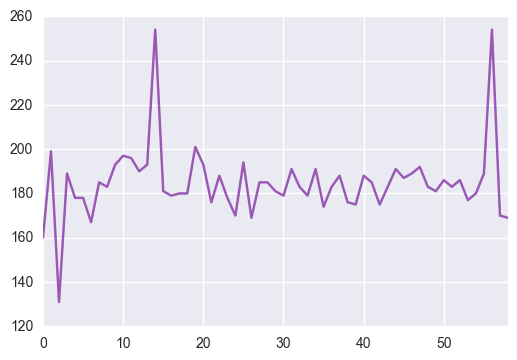

In [89]:
sns.tsplot(avg_HRs)